In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


In [13]:
ticker_input = input("Enter stock ticker (e.g., AAPL): ").upper()
period_input = input("Enter period (e.g., '6mo', '1y', '2y'): ").lower()

ticker = yf.Ticker(ticker_input)
data = ticker.history(period=period_input)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [14]:
#RSI
delta = data['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Cell 4: Moving Averages
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()

# Cell 5: MACD
ema12 = data['Close'].ewm(span=12, adjust=False).mean()
ema26 = data['Close'].ewm(span=26, adjust=False).mean()

data['MACD'] = ema12 - ema26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Cell 6: Bollinger Bands (20-day)
data['BB_Mid'] = data['Close'].rolling(window=20).mean()
rolling_std = data['Close'].rolling(window=20).std()
data['BB_Upper'] = data['BB_Mid'] + 2 * rolling_std
data['BB_Lower'] = data['BB_Mid'] - 2 * rolling_std

# Cell 7: Volume Moving Average
data['Avg_Vol'] = data['Volume'].rolling(window=20).mean()

# Cell 8: Recommendation Logic
latest = data.iloc[-1]
close = latest['Close']
score = 0
explanations = []

# RSI logic with momentum check
if latest['RSI'] < 30 and data['RSI'].iloc[-2] < 30 and latest['RSI'] > data['RSI'].iloc[-2]:
    score += 2
    explanations.append("RSI is below 30 and turning upward (oversold).")
elif latest['RSI'] > 70 and data['RSI'].iloc[-2] > 70 and latest['RSI'] < data['RSI'].iloc[-2]:
    score -= 2
    explanations.append("RSI is above 70 and turning downward (overbought).")

# MACD crossover logic
if latest['MACD'] > latest['MACD_Signal']:
    score += 1
    explanations.append("MACD shows bullish crossover.")
else:
    score -= 1
    explanations.append("MACD shows bearish crossover.")

# Trend via SMA
if close > latest['SMA50']:
    score += 1
    explanations.append("Price is above 50-day SMA (uptrend).")
else:
    score -= 1
    explanations.append("Price is below 50-day SMA (downtrend).")

# Bollinger Band signals
if close < latest['BB_Lower']:
    score += 2
    explanations.append("Price is below lower Bollinger Band (mean reversion signal).")
elif close > latest['BB_Upper']:
    score -= 2
    explanations.append("Price is above upper Bollinger Band (potential pullback).")

# Volume confirmation
if latest['Volume'] > 1.5 * latest['Avg_Vol']:
    score += 1
    explanations.append("Volume is significantly above average (strong conviction).")

# Final recommendation
if score >= 4:
    recommendation = "STRONG BUY"
elif score >= 2:
    recommendation = "BUY"
elif score <= -4:
    recommendation = "STRONG SELL"
elif score <= -2:
    recommendation = "SELL"
else:
    recommendation = "HOLD"


# Cell 9: Output Summary
print(f"\n📌 Stock: {ticker_input} ({period_input.upper()})")
print(f"🔎 Signals Summary → Score: {score}")
print(f"📈 Recommendation: {recommendation}\n")
print("🧠 Explanation:")
for e in explanations:
    print("•", e)





📌 Stock: MARA (2Y)
🔎 Signals Summary → Score: 0
📈 Recommendation: HOLD

🧠 Explanation:
• MACD shows bearish crossover.
• Price is above 50-day SMA (uptrend).


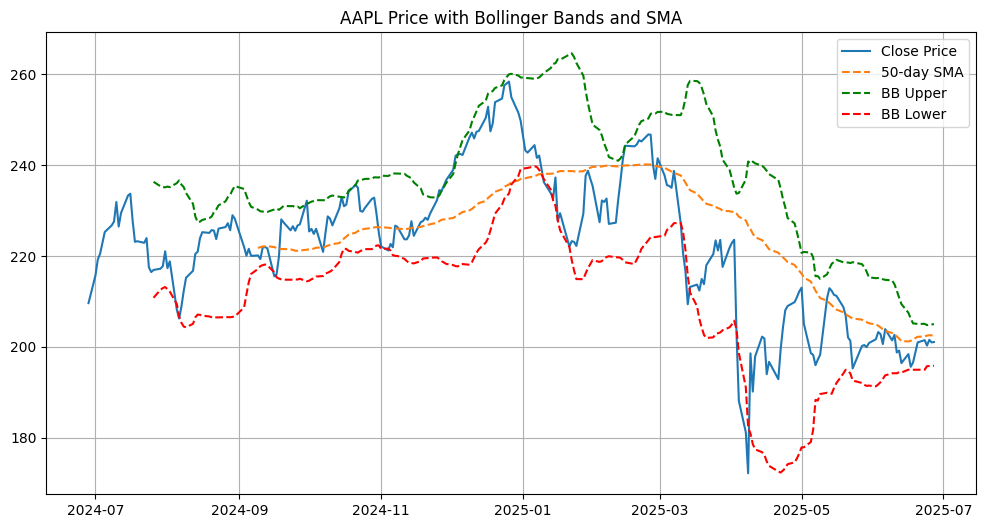

In [7]:
# Cell 10: Price & Indicators Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', linewidth=1.5)
plt.plot(data['SMA50'], label='50-day SMA', linestyle='--')
plt.plot(data['BB_Upper'], label='BB Upper', linestyle='--', color='green')
plt.plot(data['BB_Lower'], label='BB Lower', linestyle='--', color='red')
plt.title(f"{ticker_input} Price with Bollinger Bands and SMA")
plt.legend()
plt.grid(True)
plt.show()


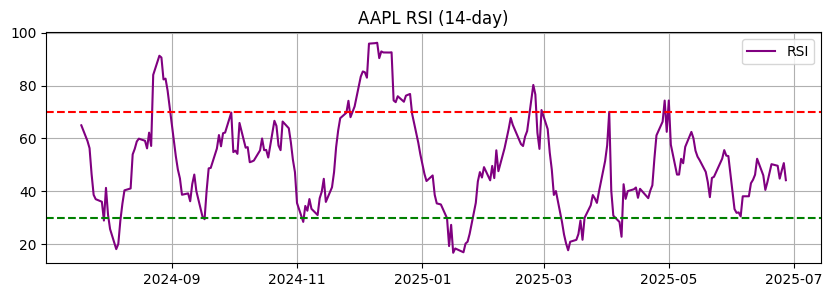

In [8]:
# Cell 11: RSI Plot
plt.figure(figsize=(10, 3))
plt.plot(data['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title(f"{ticker_input} RSI (14-day)")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Cell 12: Save Output to CSV
data.to_csv(f"{ticker_input}_technical_analysis.csv")
print(f"\n✅ Data saved to '{ticker_input}_technical_analysis.csv'")
